In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from utils import *
from datetime import datetime
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

keys = ['采集时间', '水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数','氨氮', '总磷', '总氮']
en_keys = ['WaterTemperature', 'PH' ,'dissolved oxygen', 'Conductivity','Turbidity','PermanganateIndex',
        'AmmoniaNitrogen','TP','TN', 'humidity','room temperature','chlorophyll','Algae density']
# limits = [(5, 30), (5.0, 9), (1, 15), (50, 500), (0, 1500), (0, 15), (0, 0.5), (0, 0.3), (0, 5)]

np.set_printoptions(formatter = {'float': '{:.2f}'.format})


In [ ]:
def main_func():
    

In [4]:
import torch
from trainer import *
from models import *


def preHandler(ckpt_path, df_path, pre_start_date, model_kwargs, describe_df_path, read_method, *args):
    '''
    Make Sure the excel file has no nan value.
    '''
    df = read_method(df_path, *args)
    describe = pd.read_csv(describe_df_path, index_col=0)
    pre_start_date = datetime.strptime(pre_start_date, '%Y-%m-%d')
    end_date = str(pre_start_date - timedelta(days=1))
    start_date = str(pre_start_date - timedelta(days=4))
    vals = df.loc[start_date:end_date].values[:-1]
    if np.isnan(vals).any() or vals.shape[0] != model_kwargs['lGet']:
        print('Attention!')
        print(f'The excel file has not enough data during {start_date} and {end_date}.')
        print(f'Please try another date or change the excel file')
        return 
    
    means = describe.loc['mean'].values.reshape(1, 1, 9)
    stds = describe.loc['std'].values.reshape(1, 1, 9)
    descaler = lambda x: x * stds + means
    scaler = lambda x: (x - means) / stds
    
    model = SCIModule(**model_kwargs)
    vals = vals.reshape(1, -1, 9)
    vals = scaler(vals)
    pre = prediction(ckpt_path, model, vals, model_kwargs['lPre'], model_kwargs['lGet'])
    pre = descaler(pre.transpose())
    return pre

def pre7days(ckpt_path, df_path, pre_start_date, model_kwargs, describe_df_path, read_method, *args):
    df = read_method(df_path, *args)
    describe = pd.read_csv(describe_df_path, index_col=0)
    pres = []
    
    pre_start_date = datetime.strptime(pre_start_date, '%Y-%m-%d')
    end_date = str(pre_start_date - timedelta(days=1) - timedelta(hours=4))
    start_date = str(pre_start_date - timedelta(days=4))
    
    # The first three days date
    dfn = df.loc[start_date:end_date]
    means = describe.loc['mean'].values.reshape(1, 1, 9)
    stds = describe.loc['std'].values.reshape(1, 1, 9)
    descaler = lambda x: x * stds + means
    scaler = lambda x: (x - means) / stds
    model = SCIModule(**model_kwargs)
    
    for i in range(7):
        vals = dfn.iloc[i*6:i*6+18].values
        vals = vals.reshape(1, -1, 9)
        x = scaler(vals)        
        y = prediction(ckpt_path, model, x, model_kwargs['lPre'], model_kwargs['lGet'])
        y = descaler(y.transpose()).squeeze()

        time_start = str(pre_start_date + timedelta(days=i))
        time_end = str(pre_start_date + timedelta(days=i) + timedelta(hours=20))  
        idx = pd.date_range(start=time_start, end=time_end, freq='4H')
        temp = pd.DataFrame(data=y, index=idx, columns=dfn.columns)
        dfn = pd.concat((dfn, temp))
#     df = df.loc[dfn.index]
    return dfn
    

def pre_with_vals(ckpt_path, vals, model_kwargs, describe_of_path, lGet=18):
    l, f = vals.shape
    if l != lGet or f != 9:
        print('The input data should have shape (18, 9)!')
        return 
    if np.isnan(vals).any():
        print('Illegal values in data!')
        return 
    describe = pd.read_csv(describe_df_path, index_col=0)
    means = describe.loc['mean'].values.reshape(1, 1, 9)
    stds = describe.loc['std'].values.reshape(1, 1, 9)
    descaler = lambda x: x * stds + means
    scaler = lambda x: (x - means) / stds
    model = SCIModule(**model_kwargs)
    pre = prediction(ckpt_path, model, vals, model_kwargs['lPre'], model_kwargs['lGet'])
    pre = descaler(pre.transpose())
    return pre
    
    
def prediction(ckpt_path, model, data, lPre=42, lGet=84):
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['state_dict'])
    model.freeze()

    data = data.reshape(1, 9, lGet)
    x = torch.from_numpy(data).to(torch.float32)
    y = model(x)
    y = y.numpy().squeeze()
    return y

kwargs = {'features': 9,
        'lPre': 6,
        'lGet' : 18,
        'Tree_levels':2,
        'hidden_size_rate':6,
        'loss':F.l1_loss,
        'lr':1e-3,
        'descaler':None}
    
x, y = pre7days('./lightning_logs/fujiang_all/checkpoints/fujiang.ckpt', 
                './original_data/05-涪江/涪江水质断面水质-小时尺度/元坝子审核数据查询表.xls',
                '2021-04-12', kwargs, 
                './all_data/fujiang_1d/all_describe.csv', data_factory, 3, 5, 3)
# print(pre)

ValueError: too many values to unpack (expected 2)

Index(['水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数', '氨氮', '总磷', '总氮'], dtype='object')


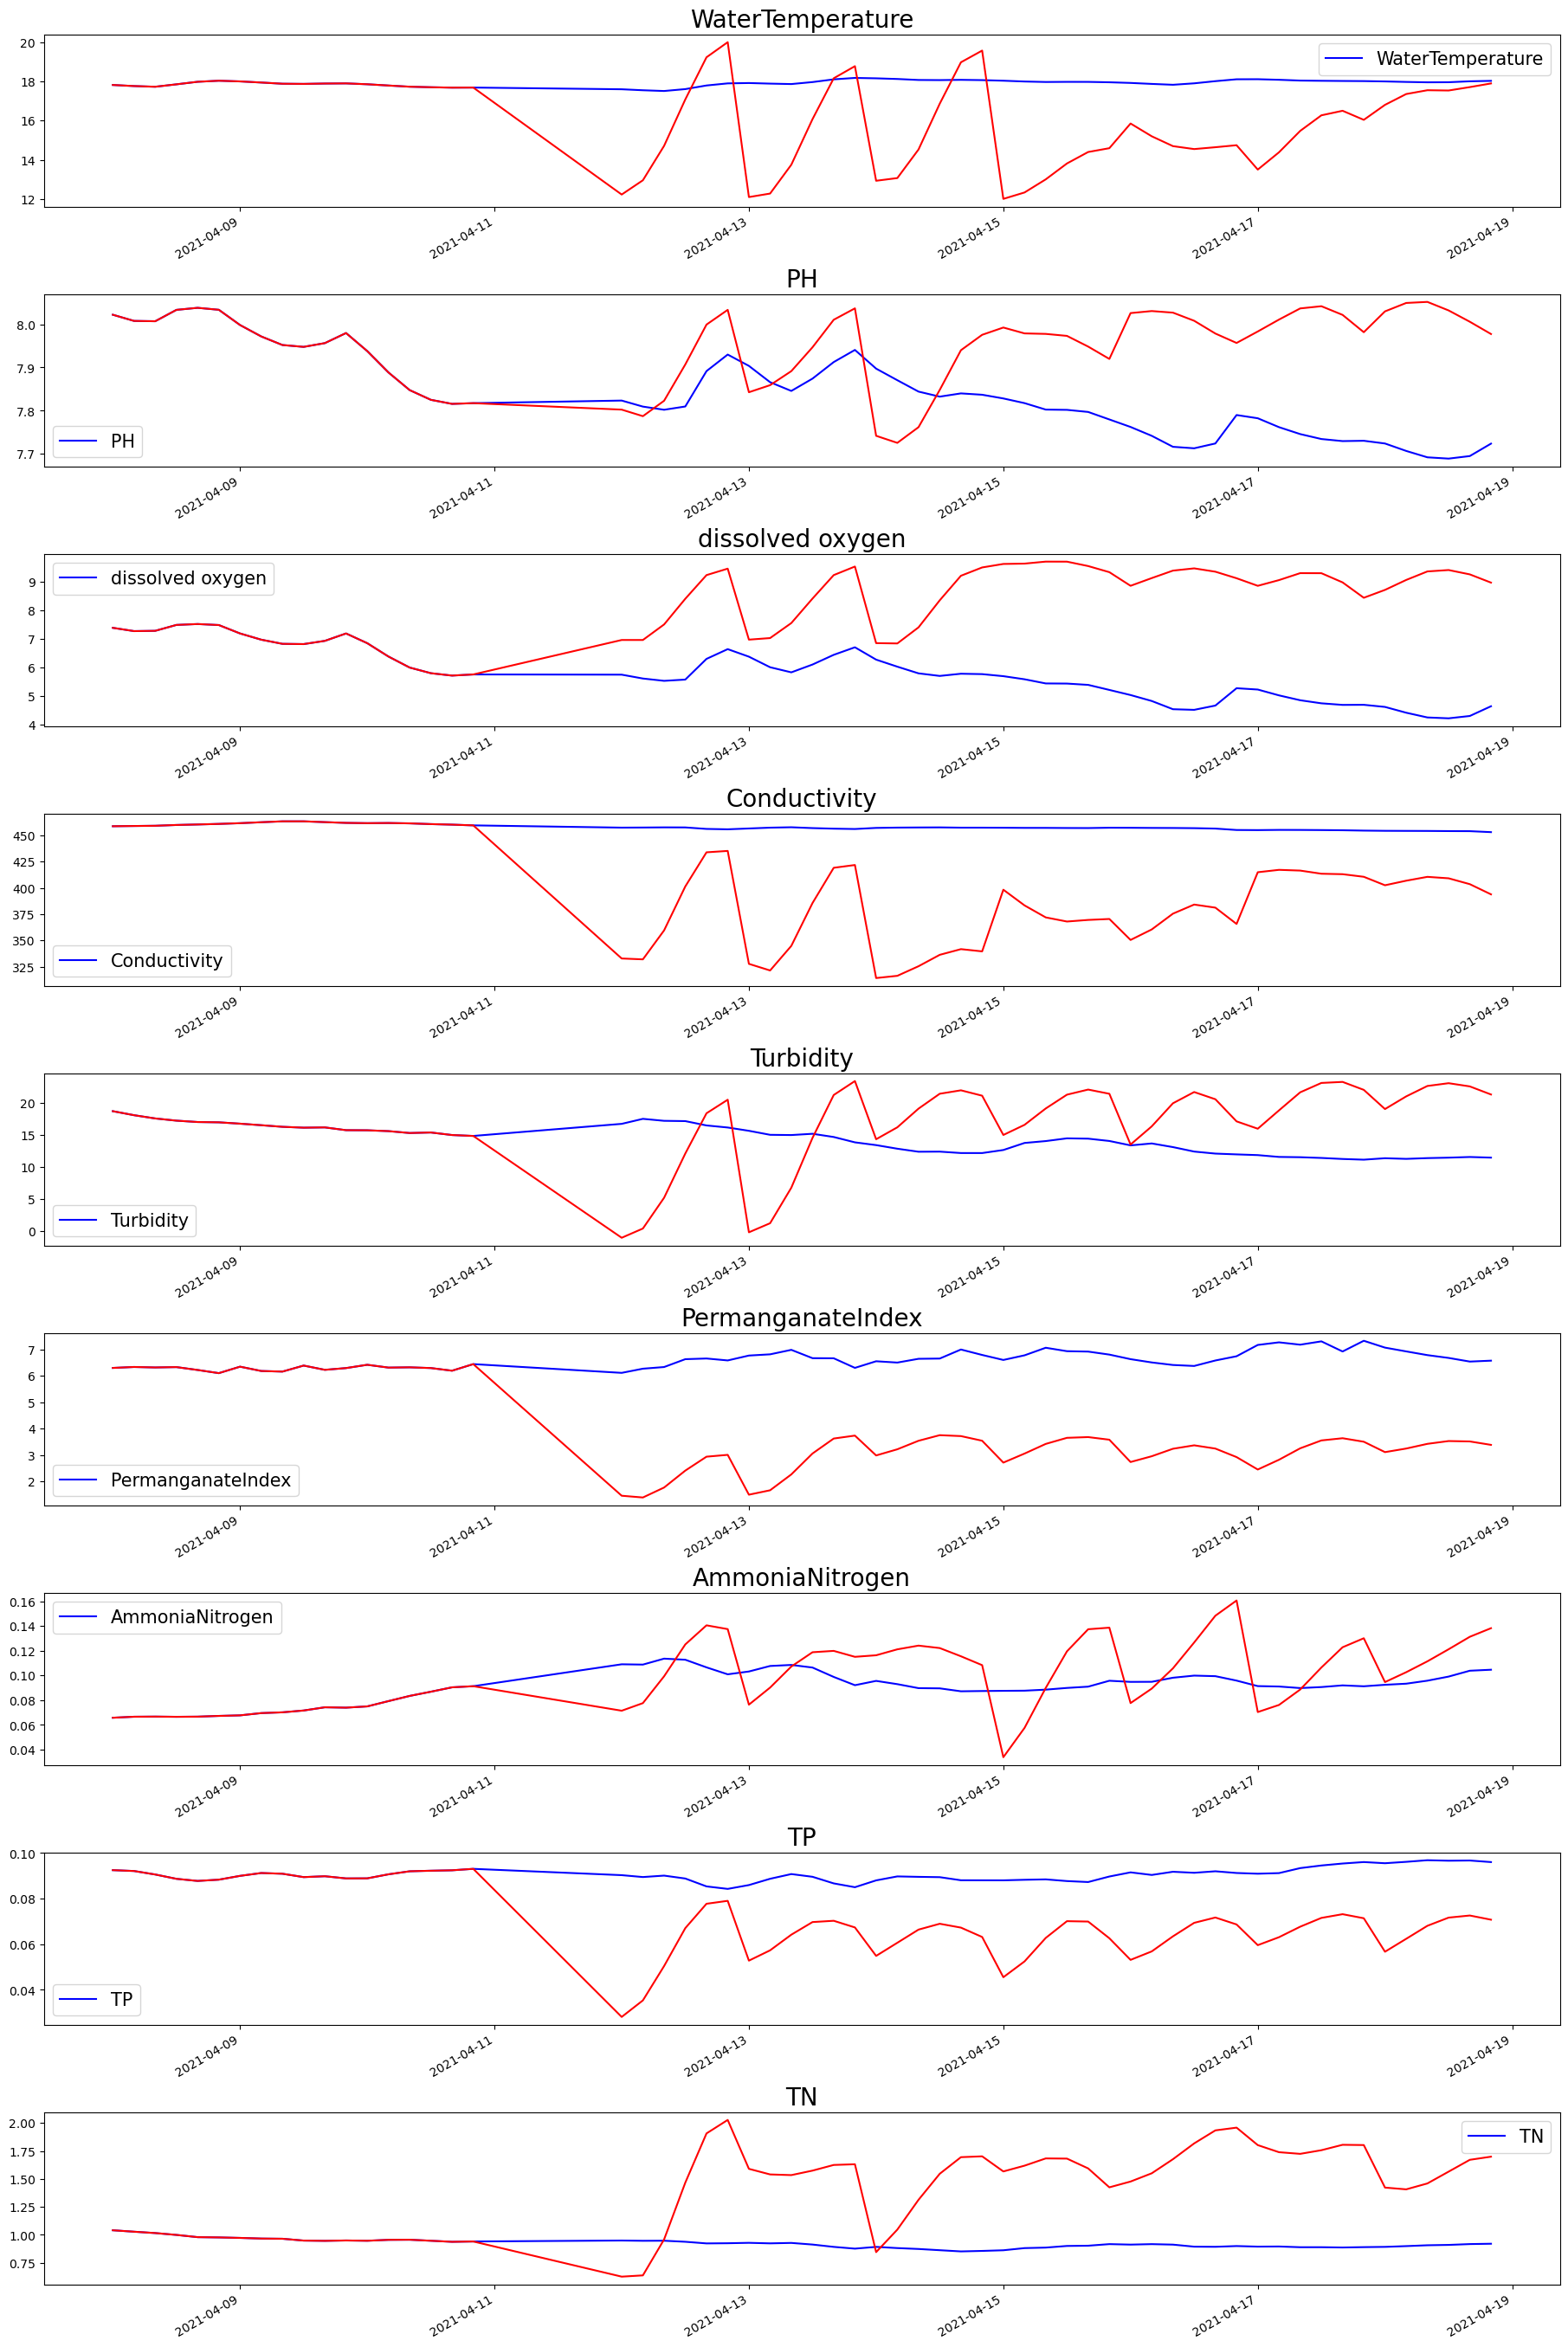

In [61]:
def plot_2df(df1, df2, keys=en_keys):
    index_nums = len(df1.keys())
    print(df1.keys())
    l, h = 18, 3
    fig, axis = plt.subplots(index_nums, 1, figsize=(l, h*index_nums), constrained_layout=True)
    for i in range(index_nums):
        name = keys[i]
        df1.plot(y=df1.keys()[i], ax=axis[i], color='b')
        df2.plot(y=df2.keys()[i], ax=axis[i], color='r')
        axis[i].set_title(name, fontsize=20)
        axis[i].set_xlabel('', fontsize=15)
        axis[i].set_ylabel('', fontsize=15)
        axis[i].legend([name], fontsize=15)
plot_2df(x, y)

In [ ]:
lPre, lGet = 42, 84
features = data.shape[1]
l, h = 25, 3

window = 8000
index = x[window:]
real = data[window:, :]
prediction = pre[window:, :]

def plot(x, data, pre, area=9000, lGet=84):
    fig, axis = plt.subplots(features, 1, figsize=(l, h*features), constrained_layout=True)

    for i in range(features):
        name = en_keys[i]
        axis[i].plot(x[:], data[:, i], '-k', linewidth=3)
        axis[i].plot(x[lGet:area+lGet], pre[:area, i], '-r', linewidth=0.8)
        axis[i].plot(x[area+lGet:], pre[area:, i], '-b', linewidth=0.8)

    #     df.plot(y=k, ax=axis[i], style='-k')
    #     df.plot(y=f'{k}(pre)', ax=axis[i], style='--r')

        axis[i].set_title(name, fontsize=20)
        axis[i].set_xlabel('', fontsize=15)
        axis[i].set_ylabel('', fontsize=15)

        axis[i].legend([name], fontsize=15)
    
plot(index, real, prediction, 9000-window)

In [ ]:
# !!! Do Not remove !!!
# Data Handler for BianJie, FuJiang, luguhu.
dataHandler('./original_data/04-四川省边界断面/四川边界断面水质数据/', 30, 6, './all_data/bianjie_1d/', data_factory, 3, 5, 3)
dataHandler('./original_data/泸沽湖邛海鲁班水库水质数据/原始查询/', 30, 6, './all_data/luguhu_1d/', data_factory, 3, 5, 3)
dataHandler('./original_data/05-涪江/涪江水质断面水质-小时尺度/', 30, 6, './all_data/fujiang_1d//', data_factory, 3, 5, 3)

In [8]:
# !!! Do Not remove !!!
# Data Handler for MinTuoJiang data
import re
from tqdm import tqdm
from utils import _gen_data
lPre, lGet = 6, 18
r, limit, step = 3, 5, 3
save_path = './all_data/mtj_1d/'
ptj_keys = ['监测时间', '水温(℃)', 'pH值(无量纲)', '溶解氧(mg/L)', '电导率(uS/cm)', '浊度(NTU)','高锰酸盐指数(mg/L)',
           '氨氮(mg/L)', '总磷(mg/L)', '总氮(mg/L)']
p = Path('./original_data/08-岷沱江数据/岷沱江水质监测数据/')
d = {}
for file in p.iterdir():
    name = re.match('\d*?\D+', file.stem)[0]
    if name in d.keys():
        d[name].append(file)
    else:
        d[name] = [file]
all_df = []
all_data = []
for k in tqdm(d.keys()):
    dfs = []
    for file in d[k]:
        df = pd.read_excel(file, header=1, usecols=ptj_keys, index_col=0, dtype=str)
        df.drop(df.index[0], axis=0, inplace=True)
        dfs.append(df)    
    df = pd.concat(dfs)
    df = df.sort_index()
    df.index=pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
    for f in df.keys():
        df[f] = df[f].str.extract('(^\d+\.\d+)')
    df = df.astype('float64')
    df = df.resample('4H').mean()
    df.loc[(df==0).all(axis=1)] = np.nan    
    df = remove_outliers(df, standard_deviation, 25)
    df[df < 0] = np.nan
    df = patch_up(df, r, limit)
    df = smooth(df, step)
    
    all_df.append(df)
    
    save_file_name = f'{save_path}{k}'
    describe_save_name = f'{save_file_name}_describe.csv'
    x = _gen_data(df, lGet, lPre, save_file_name)
    all_data.append(x)
    df.describe().to_csv(describe_save_name)

all_data = np.vstack(all_data)
np.save(f'{save_path}all',all_data)
pd.concat(all_df).describe().to_csv(f'{save_path}all_describe.csv')
    

100%|███████████████████████████████████████████| 50/50 [01:22<00:00,  1.65s/it]


In [7]:
dic = {'./original_data/04-四川省边界断面/四川边界断面水质数据/':'./all_data/bianjie_1d/', 
       './original_data/05-涪江/涪江水质断面水质-小时尺度/':'./all_data/fujiang_1d/', 
       './original_data/泸沽湖邛海鲁班水库水质数据/原始查询/':'./all_data/luguhu_1d/',}
from utils import _gen_data
def merge_all(path_dict, lGet, lPre):
    for path in path_dict.keys():
        p = Path(path)
        save_path = path_dict[path]
        nouse = [f.unlink() for f in Path(save_path).iterdir() if f.is_file()]
        dfs = []
        data = []
        print(p)
        for file in p.iterdir():
            dfs.append(data_factory(file, 3, 5, 3))
            save_file_name = f'{save_path}{file.stem}'
            describe_save_name = f'{save_path}{file.stem}_describe.csv'
            data.append(_gen_data(df, lGet, lPre, save_file_name))
            df.describe().to_csv(describe_save_name)
        
        describe = pd.concat(dfs).describe()
        describe.to_csv(f'{save_path}all_describe.csv')
        np.save(f'{save_path}all', np.vstack(data, ))
    return 
merge_all(dic, 18, 6)

original_data/04-四川省边界断面/四川边界断面水质数据
original_data/05-涪江/涪江水质断面水质-小时尺度
original_data/泸沽湖邛海鲁班水库水质数据/原始查询


In [3]:
def remove_str(strs, s):
    for part in strs:
        s = s.replace(part, '')
    return s

s = '原始查询（泸沽湖湖心-泸沽湖）.xls'
print(remove_str(['（', '）', '原始查询'], s))


泸沽湖湖心-泸沽湖.xls
